In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import vanilla_autoencoder

In [2]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/


In [ ]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session
sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n = data_handler.generate_dataset(feature_selection_threshold = 5, 
                                                   feature_selection_proceedure = "LASSO", 
                                                   retain_phases="2", 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params,
                                                   subsample = 500)


In [10]:
#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True, batch_size = 128)

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = None, 
                                                   feature_selection_proceedure = "LASSO", 
                                                   retain_phases="2", 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params)

retained phase 2
2870
2858
2787
loading samples...
loaded 2787 samples
0       1.0
1       1.0
2       1.0
3       1.0
4       2.0
       ... 
2782    1.0
2783    1.0
2784    1.0
2785    1.0
2786    1.0
Name: Cohort, Length: 2787, dtype: float64
[1. 1. 1. ... 1. 1. 1.]
selecting genes based on median absolute deviation threshold:  5 ...
selecting genes based on LASSO-like classification...
standardisation for LASSO regression...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
best score: 0.7463208560967292
best estimator: SGDClassifier(alpha=0.1, l1_ratio=0.1, loss='log', penalty='elasticnet')
best_estimator_.coef_: [[0.         0.         0.         ... 0.01518658 0.01735338 0.01065955]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
SUM best_estimator_.coef_: 0.4773038914508342
best_estimator_.interce

In [11]:
latent_dim = 64
t_shape = (6161)

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [12]:
checkpoint_filepath = '../workfiles/simple_autoencoer_model/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [ ]:
%tensorboard --logdir ../workfiles/logs/fit


In [13]:
hist = autoencoder.fit(x_train, epochs=1000, callbacks=cb)

Epoch 1/1000


2023-07-21 17:00:28.682904: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


44/44 [==============================] - 1s 8ms/step - loss: 27061.7611 - lr: 0.0010
Epoch 2/1000
44/44 [==============================] - 0s 6ms/step - loss: 2004.9662 - lr: 0.0010
Epoch 3/1000
44/44 [==============================] - 0s 8ms/step - loss: 1616.8408 - lr: 0.0010
Epoch 4/1000
44/44 [==============================] - 0s 9ms/step - loss: 1211.5840 - lr: 0.0010
Epoch 5/1000
44/44 [==============================] - 1s 14ms/step - loss: 960.0240 - lr: 0.0010
Epoch 6/1000
44/44 [==============================] - 0s 10ms/step - loss: 895.6621 - lr: 0.0010
Epoch 7/1000
44/44 [==============================] - 0s 9ms/step - loss: 779.8087 - lr: 0.0010
Epoch 8/1000
44/44 [==============================] - 0s 9ms/step - loss: 715.1760 - lr: 0.0010
Epoch 9/1000
44/44 [==============================] - 0s 9ms/step - loss: 667.9481 - lr: 0.0010
Epoch 10/1000
44/44 [==============================] - 0s 9ms/step - loss: 603.5266 - lr: 0.0010
Epoch 11/1000
44/44 [========================

In [14]:
autoencoder.load_weights(checkpoint_filepath)


[12141.23828125, 1800.2322998046875, 1474.5958251953125, 1135.8924560546875, 923.9437866210938, 854.9802856445312, 749.9727783203125, 688.1737670898438, 637.1384887695312, 582.6433715820312, 541.5100708007812, 514.3126831054688, 531.6390380859375, 494.5462341308594, 461.1297607421875, 472.251708984375, 443.21600341796875, 413.919189453125, 541.4367065429688, 466.3255615234375, 404.02752685546875, 369.9599609375, 344.8161926269531, 334.3406982421875, 320.72796630859375, 353.0430908203125, 322.9117431640625, 303.7936096191406, 314.4786376953125, 316.00616455078125, 300.43792724609375, 302.3527526855469, 284.4178161621094, 301.04974365234375, 296.0568542480469, 270.97882080078125, 312.0386962890625, 285.4677734375, 312.424072265625, 291.71087646484375, 278.0867919921875, 264.54461669921875, 261.6832275390625, 276.9344787597656, 252.8291778564453, 249.24368286132812, 348.3006896972656, 288.9971923828125, 290.7583312988281, 249.72296142578125, 262.5479431152344, 237.26075744628906, 263.6678

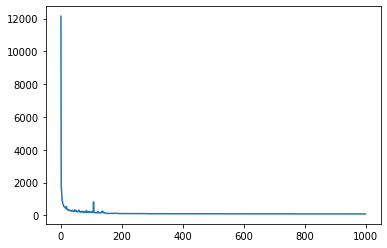

In [15]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])




### some diagnosis

In [16]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
z

<tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[-13.787437 ,  97.883965 , 222.09802  , ...,  14.197707 ,
         14.850749 , -68.13114  ],
       [-32.565773 , 247.82065  ,  61.67841  , ...,  75.27834  ,
        -26.132921 , -75.135925 ],
       [ 25.862938 , 362.3298   , 158.40549  , ...,  18.338205 ,
         -8.05656  ,  73.37854  ],
       ...,
       [-48.50122  , 225.15123  , -83.889    , ..., 181.95186  ,
         10.883031 ,  44.2167   ],
       [ 82.64395  , 193.64215  ,  48.85143  , ..., -40.174175 ,
        -12.801554 ,  79.4467   ],
       [-26.735716 , 358.00763  , 124.35145  , ..., -80.89135  ,
          4.1954184,  17.242329 ]], dtype=float32)>

In [17]:
print(autoencoder.decoder(z))
print(e)

tf.Tensor(
[[220.1229     42.092934   53.41853   ...  22.085325   15.309712
   46.763855 ]
 [ 83.29142    39.32128    43.36155   ...   8.562752   34.30778
   45.330776 ]
 [275.82162    42.144875   60.699783  ...  61.159904   19.509857
   94.52651  ]
 ...
 [ 21.750511   49.07874    48.912754  ...  53.744274   74.81446
  106.26806  ]
 [ 67.69568    13.399951   25.930614  ...   7.8187003  10.066827
   26.816704 ]
 [139.16086    31.447292   44.398045  ... 263.53287   466.56787
  227.47797  ]], shape=(64, 299), dtype=float32)
tf.Tensor(
[[220.86     42.8445   57.2647  ...  21.601    14.5302   43.2891 ]
 [ 78.4157   53.5464   59.6809  ...  28.7308   33.4212   42.899  ]
 [266.8      46.1504   59.7187  ...  37.2859   22.7498   95.4406 ]
 ...
 [ 37.3662   41.5532   45.2168  ...  68.5695   75.1809  106.025  ]
 [ 63.9382   12.8246   23.347   ...  10.1002    9.85647  22.114  ]
 [134.357    34.7222   46.478   ... 262.931   465.423   224.967  ]], shape=(64, 299), dtype=float32)


In [18]:
autoencoder.encoder.save('../workfiles/simple_autoencoer_model')


INFO:tensorflow:Assets written to: ../workfiles/simple_autoencoer_model/assets


In [19]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

44/44 [==============================] - 0s 901us/step


In [20]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [22]:
#df.to_csv("../workfiles/compressed_data_simple_autoencoder_phase_2.csv")
df.to_csv("../workfiles/LASSO_proper.csv", index=False)
